In [1]:
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import random
import matplotlib as mpl
import os
import gc
from torch.utils.tensorboard import SummaryWriter
from datetime import date
mpl.rcParams['figure.dpi'] = 180

In [2]:
# Set up the Cuda device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# LSTM Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, seq_len,num_classes=1):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.seq_len = seq_len

        self.bnn = nn.Linear(input_size, 1024) #go from 1308 to 1024

        self.lstm1 = nn.LSTM(1024, hidden_size1, num_layers, batch_first=True, bidirectional=True, dropout=0.5) #go from 1024 to 512

        self.lstm2 = nn.LSTM(2*hidden_size1, 64, num_layers, batch_first=True, bidirectional=True, dropout=0.5) #go from 512 to 256

        self.nn1 = nn.Linear(2*hidden_size2,hidden_size2) #go from 128 to 64
        self.nn2 = nn.Linear(hidden_size2, 1) #go from 64 to 1 for output

        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.5)



    def forward(self, x, array_lengths):
        # Set initial hidden states (and cell states for LSTM)
        # print(x.size(0))
        inital_seq_len = x.size(1)
        x = Variable(x.float()).to(device)

        x = torch.reshape(x, (x.size(0)*x.size(1), x.size(2)))

        ## before nn
        out = self.bnn(x)
        out = self.relu(out)

        ## reshaping again
        out = torch.reshape(out, (-1, inital_seq_len, out.size(1)))
        # print(out.size()) to check the size of the tensor

        pack = nn.utils.rnn.pack_padded_sequence(out, array_lengths, batch_first=True, enforce_sorted=False)
        h0 = Variable(torch.zeros(2*self.num_layers, x.size(0), self.hidden_size1).to(device))
        c0 = Variable(torch.zeros(2*self.num_layers, x.size(0), self.hidden_size1).to(device))
        h1 = Variable(torch.zeros(2*self.num_layers, self.hidden_size1, self.hidden_size2).to(device))        
        c1 = Variable(torch.zeros(2*self.num_layers, self.hidden_size1, self.hidden_size2).to(device))

        # Forward propagate RNN
        out, _ = self.lstm1(pack, (h0,c0))
        del(h0)
        del(c0)
        out, _ = self.lstm2(out, (h1,c1))
        del(h1)
        del(c1)
        gc.collect()
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        this_batch_len = unpacked.size(1)
        out = unpacked
        out = torch.reshape(out, (out.size(0)*out.size(1), out.size(2)))

        ##nn
        out = self.nn1(out)
        out = self.relu(out)
        out = self.nn2(out)

        ## reshaping
        out = torch.reshape(out, (-1, this_batch_len, 1))

        return out

In [4]:
epoch_check =400
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is',device)

model_test = torch.load('/home/tjdean2/research_data/CHBE594/class_project/models/LSTM_smaller/epoch_'+ str(epoch_check) + '.pth', map_location='cuda')
model_test.eval().to(device)
print(model_test)
for p in model_test.parameters():
    print(p.size())

params = sum([np.prod(p.size()) for p in model_test.parameters()])
print(params)

Device is cuda
RNN(
  (bnn): Linear(in_features=1308, out_features=1024, bias=True)
  (lstm1): LSTM(1024, 512, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm2): LSTM(1024, 64, batch_first=True, dropout=0.5, bidirectional=True)
  (nn1): Linear(in_features=128, out_features=64, bias=True)
  (nn2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
)
torch.Size([1024, 1308])
torch.Size([1024])
torch.Size([2048, 1024])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
torch.Size([2048, 1024])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
torch.Size([256, 1024])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 1024])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([64, 128])
torch.Size([64])
torch.Size([1, 64])
torch.Size([1])
8206465


In [5]:
x_test = np.load('x_test_35.npy', allow_pickle=True)
# dataset preparation
class BetaDataset(Dataset) :
    def __init__(self,x,y, n_samples) :
        # data loading
        self.x = x
        self.y = y 
        self.n_samples = n_samples
        
        
    def __getitem__(self,index) :
        return self.x[index], self.y[index]

    def __len__(self) :    
        return self.n_samples      

test_dataset = BetaDataset(x_test,x_test,np.shape(x_test)[0])


test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

print('Number of test data set', np.shape(x_test)[0])

Number of test data set 120


In [6]:
from math import nan

all_x = np.load('/home/tjdean2/research_data/CHBE594/class_project/dataset/x_full_3000_fixed' + '.npy', allow_pickle=True)
all_y = np.load('/home/tjdean2/research_data/CHBE594/class_project/dataset/y_3000' + '.npy', allow_pickle=True)

# test_loader = test_loader[15:20,:]
p_beta = torch.zeros((1)).to(device)
a_beta = torch.zeros((1)).to(device)
collection_test = 0
avg_pearson_count = 0
avg_pearson = 0
avg_r2 = 0
count_all = 0
pearson_coeff = torch.zeros((np.shape(x_test)[0], ))
pearson_count = 0
with torch.no_grad():
  for i, (parameters, no_req) in enumerate(test_loader):
    input_x = torch.from_numpy(all_x[parameters,:,:]).to(device)
    output_y = torch.from_numpy(all_y[parameters,:,:]).to(device)
    input_x = torch.reshape(input_x, (input_x.size(0), input_x.size(2), input_x.size(3)))
    output_y = torch.reshape(output_y, (output_y.size(0), output_y.size(2), output_y.size(3)))
    
    # forward pass  
    array_lengths = input_x[:,0,1308]
    array_lengths = array_lengths.int()
    array_lengths = array_lengths.tolist()
    outputs = model_test(input_x[:,:,0:1308], array_lengths)
    outputs = torch.reshape(outputs, (-1,int(max(array_lengths))) )
    output_y = torch.reshape(output_y[:,0:int(max(array_lengths)), 0], (-1,int(max(array_lengths))))

    outputs = outputs.T
    output_y = output_y.T

    for j in range(input_x.size()[0]):    
      prot_len = int(input_x[j,0,1308].item())
      if prot_len != 0:
        a_beta = torch.cat((torch.flatten(output_y[0:prot_len,j].float()), a_beta.float()),0)
        p_beta = torch.cat((torch.flatten(outputs[0:prot_len,j].float()), p_beta.float()),0)
        
        if math.isnan(np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1]):
          print('nan')
        else:
          avg_pearson =  (avg_pearson*avg_pearson_count + np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1])/(avg_pearson_count+1)
          avg_r2 = (avg_r2*avg_pearson_count + r2_score(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu()))/(avg_pearson_count+1)
          avg_pearson_count += 1
          count_all = count_all + prot_len
          
          pearson_coeff[pearson_count,] = np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1]
          pearson_count += 1
          if pearson_coeff[pearson_count-1,] < 0.0:
            print(prot_len)

    
    del(input_x)
    del(output_y)
    gc.collect()

a_beta = a_beta[1:,]
p_beta = p_beta[1:,]

print('Total data collected', a_beta.size(0))
print('Total data predicted', p_beta.size(0))
print('Avgerage Pearson coefficient is', avg_pearson)
print('min', torch.min(pearson_coeff[0:pearson_count]))
print('max', torch.max(pearson_coeff[0:pearson_count]))

Total data collected 30357
Total data predicted 30357
Avgerage Pearson coefficient is 0.6042285521673381
min tensor(0.1753)
max tensor(0.9190)


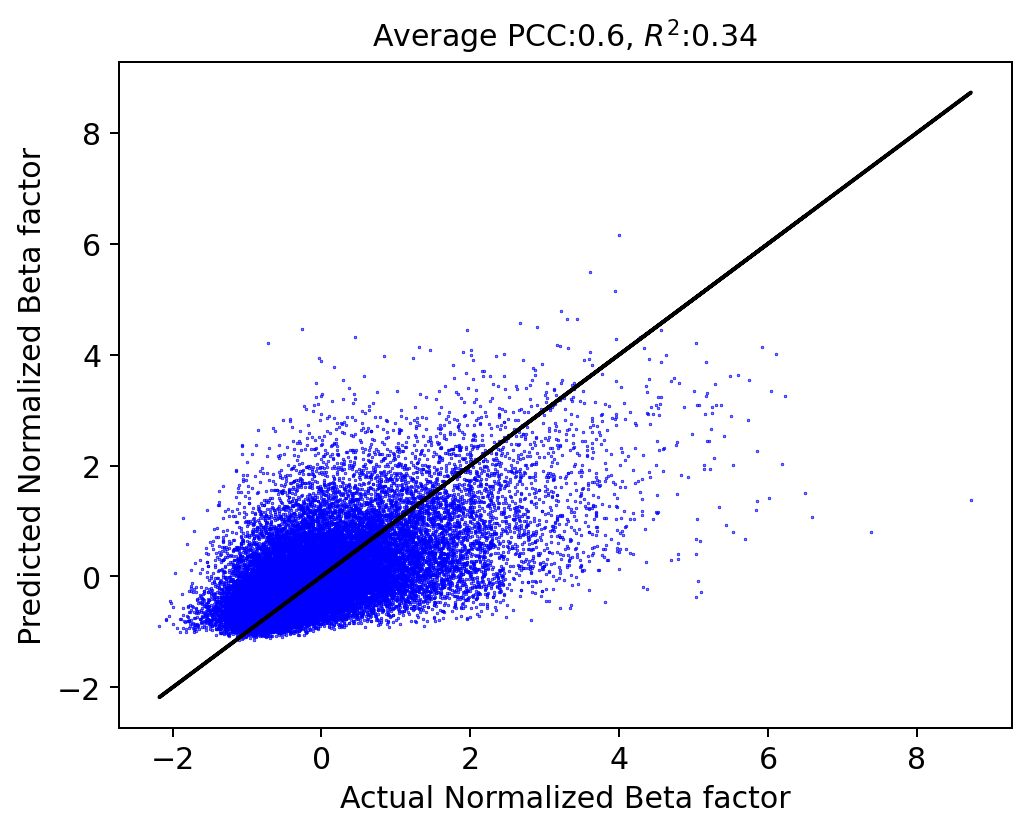

In [7]:
# combined = np.zeros((1,a_ebya))
with torch.no_grad():
    plt.figure(1)
    # plt.rcParams.update({'font.size': 16})
    plt.scatter(a_beta.cpu(), p_beta.cpu(), s=0.1, color='blue')
    plt.plot(a_beta.cpu(), a_beta.cpu(),'k')
    plt.title(f'Average PCC:{round(avg_pearson,2)}, $R^2$:{round(r2_score(a_beta.cpu(), p_beta.cpu()),2)}')
    plt.xlabel(r'Actual Normalized Beta factor', fontsize=12)
    plt.ylabel(r'Predicted Normalized Beta factor', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

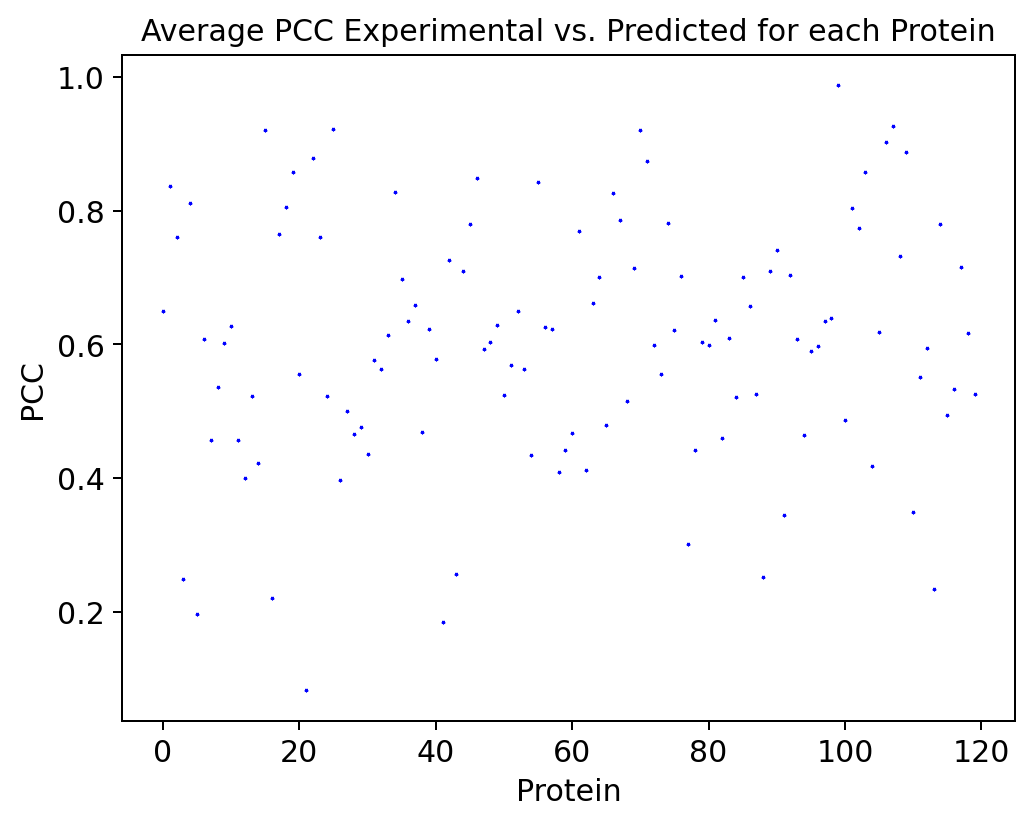

In [10]:
plt.figure(1)
plt.plot(pearson_coeff, '*', markersize=1, color='blue')
plt.title('Average PCC Experimental vs. Predicted for each Protein', fontsize=12)
plt.ylabel(r'PCC', fontsize=12)
plt.xlabel(r'Protein', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('small_PCC_exp_vs_pred_test.png',dpi=300)
plt.show()

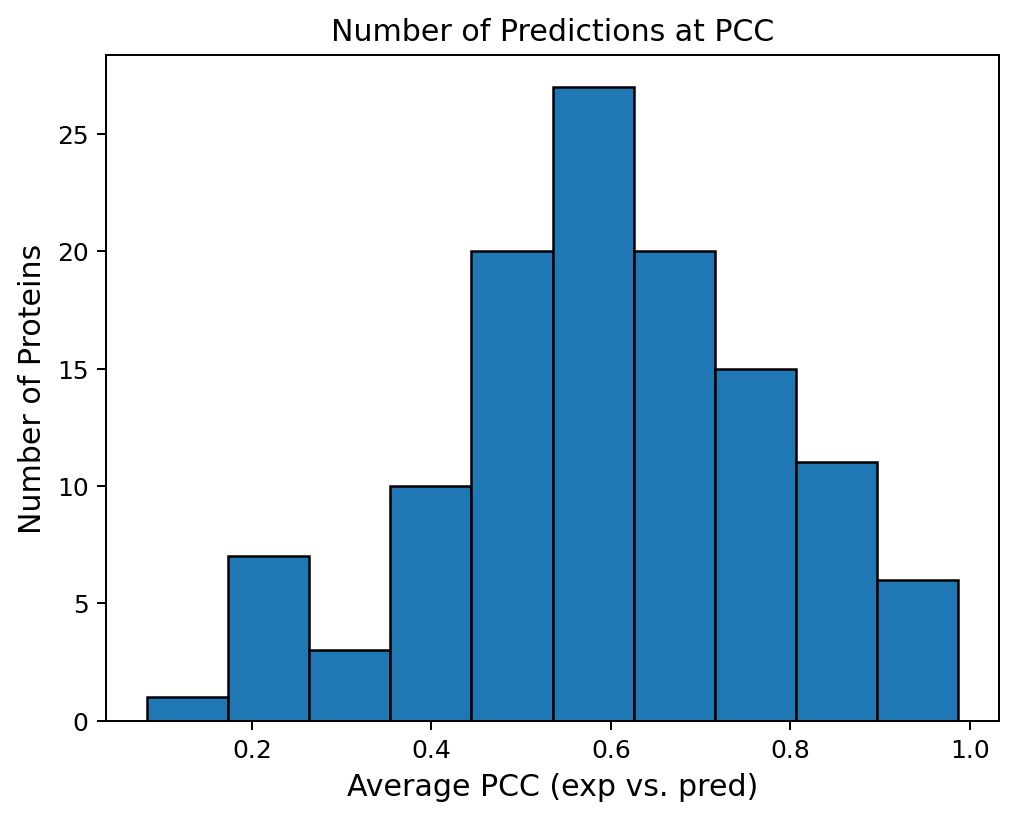

In [12]:
n, bins, patches = plt.hist(pearson_coeff, bins=10,edgecolor='black')
plt.title(r'Number of Predictions at PCC', fontsize=12)
plt.xlabel(r'Average PCC (exp vs. pred)', fontsize=12)
plt.ylabel(r'Number of Proteins', fontsize=12)
plt.savefig('small_Pred_pcc_range.png',dpi=300)
plt.show()